**data loading**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
Preparing dataset...
Found 1 case directories
Selected 1 cases
Processed 1/10: brain_tumor_000.png
Processed 2/10: brain_tumor_001.png
Processed 3/10: brain_tumor_002.png
Processed 4/10: brain_tumor_003.png
Processed 5/10: brain_tumor_004.png
Processed 6/10: brain_tumor_005.png
Processed 7/10: brain_tumor_006.png
Processed 8/10: brain_tumor_007.png
Processed 9/10: brain_tumor_008.png
Processed 10/10: brain_tumor_009.png
Dataset preparation completed!
Visualizing prepared dataset...


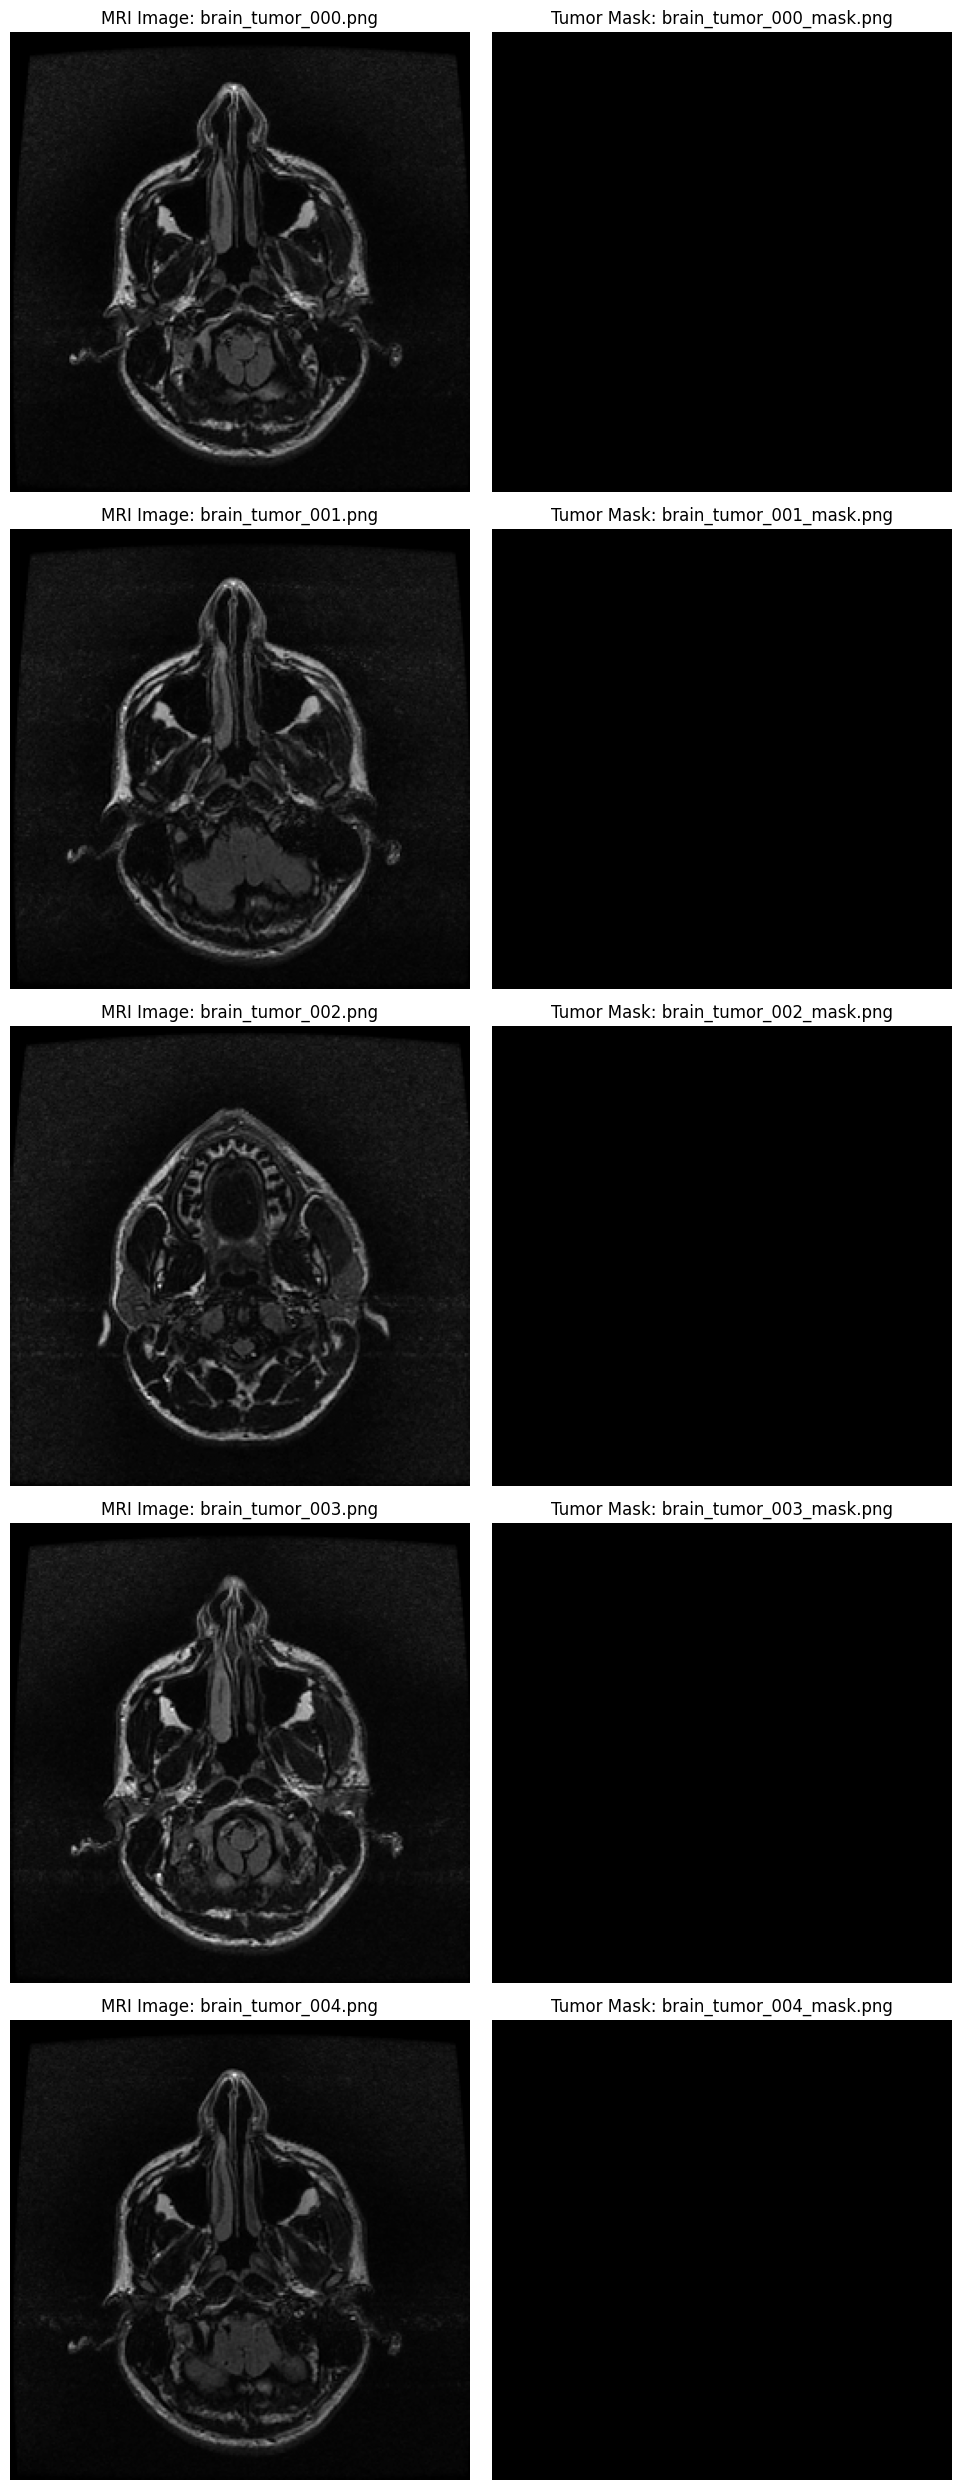


Dataset is ready to use with the brain tumor segmentation code!
Images directory: /content/drive/MyDrive/brain_tumor_dataset/images
Masks directory: /content/drive/MyDrive/brain_tumor_dataset/masks

Update these paths in the main code:
base_dir = ' /content/drive/MyDrive/brain_tumor_dataset '
images_dir = os.path.join(base_dir, 'images')
masks_dir = os.path.join(base_dir, 'masks')


In [4]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive if in Colab
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except:
    print("Running locally or Drive already mounted")

# Set paths
# Adjust these paths based on where you unzipped the LGG dataset
lgg_dataset_path = '/content/drive/MyDrive/ddd'  # Path to the original LGG dataset
output_dir = '/content/drive/MyDrive/brain_tumor_dataset'  # Where to save the organized dataset

# Create output directories
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'masks'), exist_ok=True)

# Function to extract and prepare dataset
def prepare_dataset(num_samples=10, random_selection=True):
    """
    Prepare a subset of the LGG dataset for segmentation

    Parameters:
    -----------
    num_samples : int
        Number of image-mask pairs to extract
    random_selection : bool
        Whether to select random samples or the first ones
    """
    # Get all case directories
    case_dirs = [d for d in os.listdir(lgg_dataset_path)
                if os.path.isdir(os.path.join(lgg_dataset_path, d))]

    print(f"Found {len(case_dirs)} case directories")

    if random_selection:
        # Randomly select cases
        selected_cases = random.sample(case_dirs, min(len(case_dirs), num_samples))
    else:
        # Take the first N cases
        selected_cases = case_dirs[:min(len(case_dirs), num_samples)]

    print(f"Selected {len(selected_cases)} cases")

    # Counter for processed images
    processed_count = 0

    # Process each selected case
    for case_id in selected_cases:
        case_dir = os.path.join(lgg_dataset_path, case_id)

        # Get all files in this case directory
        files = os.listdir(case_dir)

        # Get image files (without _mask suffix)
        image_files = [f for f in files if f.endswith('.tif') and '_mask' not in f]

        for img_file in image_files:
            # Get corresponding mask file
            mask_file = img_file.replace('.tif', '_mask.tif')

            if mask_file in files:
                # Full paths
                img_path = os.path.join(case_dir, img_file)
                mask_path = os.path.join(case_dir, mask_file)

                # Read images
                img = cv2.imread(img_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                if img is not None and mask is not None:
                    # Convert BGR to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Take only the FLAIR channel (channel 1) from the original image
                    # In LGG dataset, FLAIR is the 2nd channel (index 1)
                    flair = img[:, :, 1]

                    # Output filenames
                    out_img_name = f"brain_tumor_{processed_count:03d}.png"
                    out_mask_name = f"brain_tumor_{processed_count:03d}_mask.png"

                    # Save paths
                    out_img_path = os.path.join(output_dir, 'images', out_img_name)
                    out_mask_path = os.path.join(output_dir, 'masks', out_mask_name)

                    # Save images
                    cv2.imwrite(out_img_path, flair)
                    cv2.imwrite(out_mask_path, mask)

                    processed_count += 1
                    print(f"Processed {processed_count}/{num_samples}: {out_img_name}")

                    if processed_count >= num_samples:
                        return

# Function to visualize the prepared dataset
def visualize_dataset(dataset_path, num_samples=5):
    """
    Visualize the prepared dataset

    Parameters:
    -----------
    dataset_path : str
        Path to the prepared dataset
    num_samples : int
        Number of samples to visualize
    """
    images_dir = os.path.join(dataset_path, 'images')
    masks_dir = os.path.join(dataset_path, 'masks')

    # Get all image files
    image_files = sorted(os.listdir(images_dir))

    # Limit to the requested number of samples
    image_files = image_files[:min(len(image_files), num_samples)]

    # Create figure
    plt.figure(figsize=(10, 5 * len(image_files)))

    for i, img_file in enumerate(image_files):
        # Get corresponding mask file - handle different naming conventions
        if img_file.replace('.png', '_mask.png') in os.listdir(masks_dir):
            mask_file = img_file.replace('.png', '_mask.png')
        else:
            # Try alternative mask naming if needed
            mask_file = next((m for m in os.listdir(masks_dir) if m.startswith(img_file.split('.')[0])), None)

        if mask_file:
            # Read images
            img_path = os.path.join(images_dir, img_file)
            mask_path = os.path.join(masks_dir, mask_file)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Display image
            plt.subplot(len(image_files), 2, i * 2 + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"MRI Image: {img_file}")
            plt.axis('off')

            # Display mask
            plt.subplot(len(image_files), 2, i * 2 + 2)
            plt.imshow(mask, cmap='gray')
            plt.title(f"Tumor Mask: {mask_file}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Execute dataset preparation
print("Preparing dataset...")
prepare_dataset(num_samples=10, random_selection=True)
print("Dataset preparation completed!")

# Visualize the prepared dataset
print("Visualizing prepared dataset...")
visualize_dataset(output_dir, num_samples=5)

# Print instructions for using the dataset with the segmentation code
print("\nDataset is ready to use with the brain tumor segmentation code!")
print(f"Images directory: {os.path.join(output_dir, 'images')}")
print(f"Masks directory: {os.path.join(output_dir, 'masks')}")
print("\nUpdate these paths in the main code:")
print("base_dir = '", output_dir, "'")
print("images_dir = os.path.join(base_dir, 'images')")
print("masks_dir = os.path.join(base_dir, 'masks')")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!

--------------------------------------------------
Running segmentation with THRESHOLD method
--------------------------------------------------
Loading dataset...
Loaded 10 images and 10 masks.
Preprocessing images...
Preprocessed 10 images.
Segmenting tumors using threshold method...
Segmented 10 images.
Segmentation Evaluation Metrics:
  Dice Coefficient (F1-Score): 0.0000
  Jaccard Index (IoU): 0.0000
  Precision: 0.0000
  Recall: 1.0000


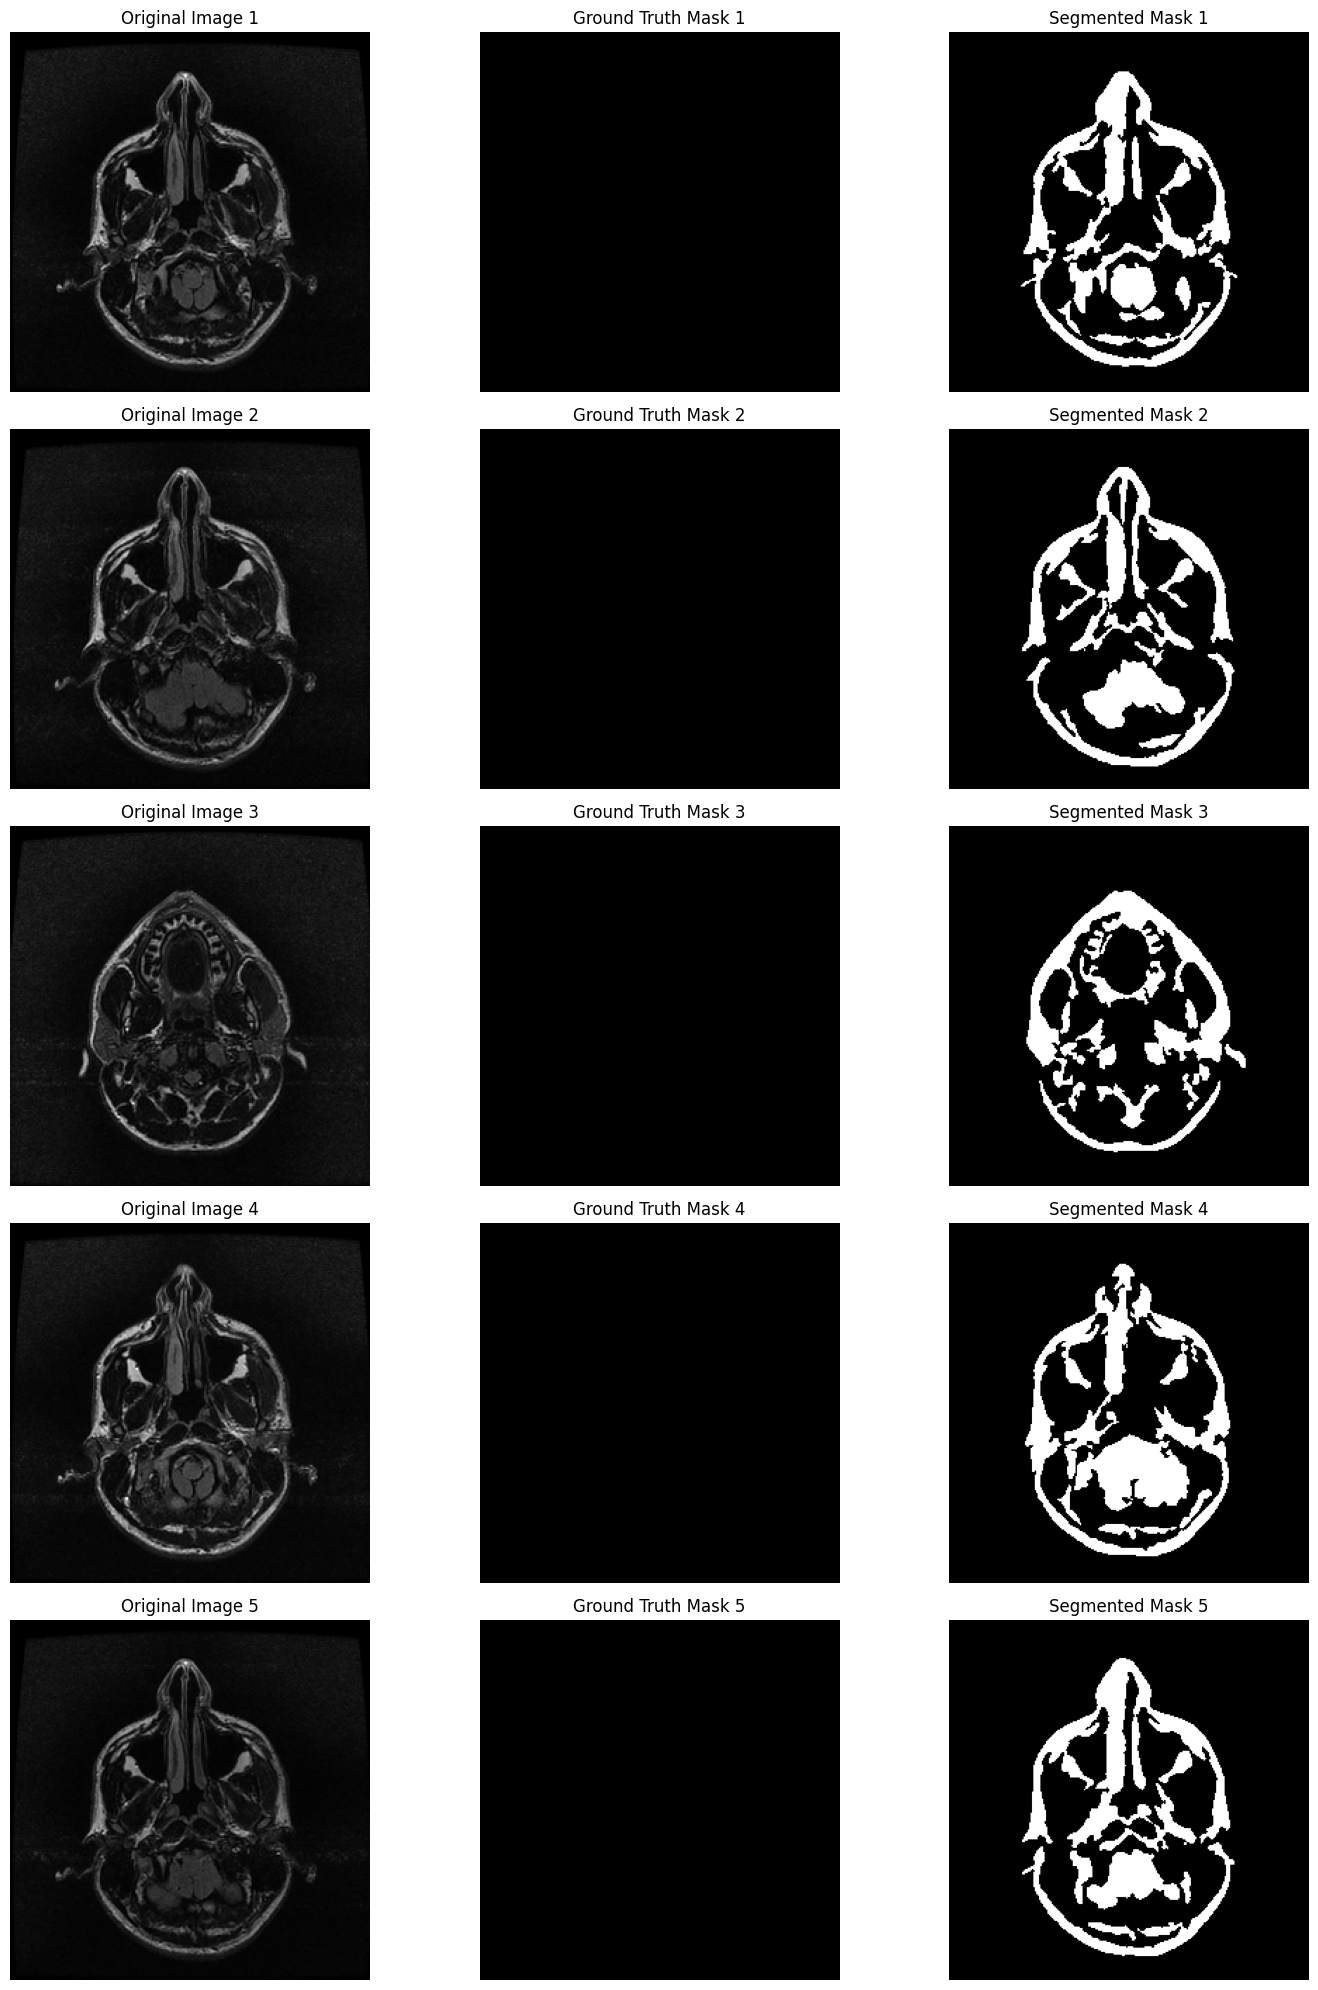

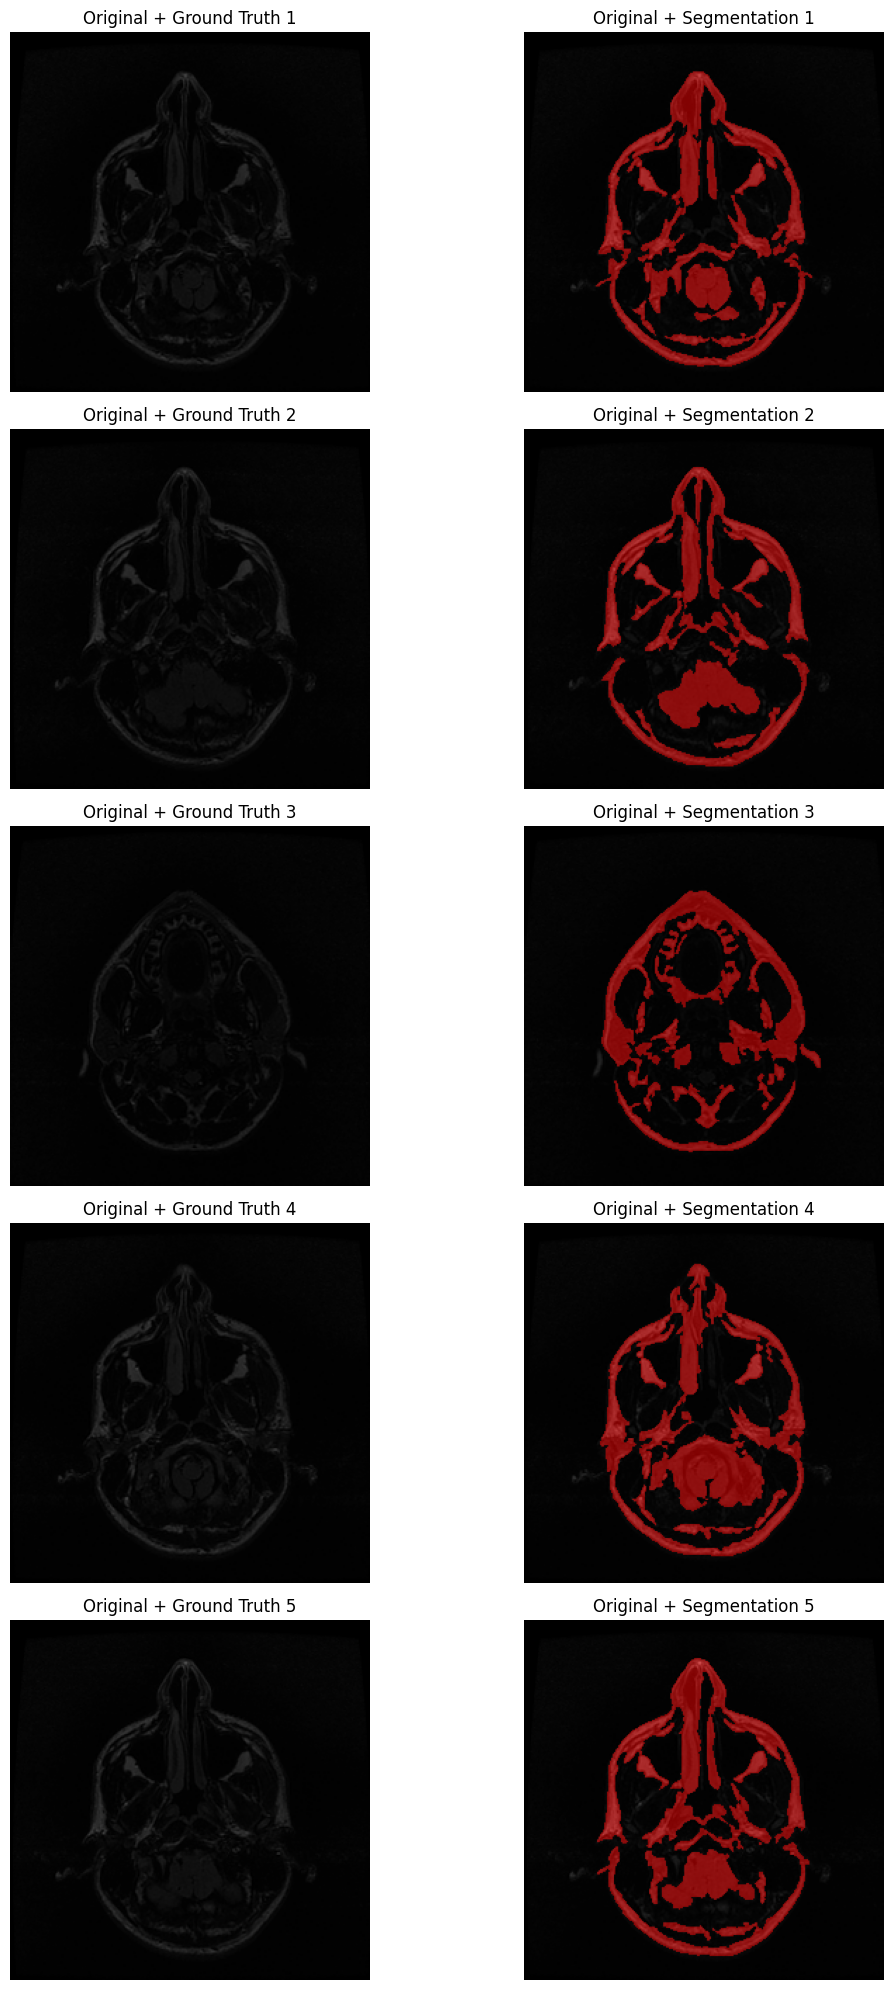


--------------------------------------------------
Running segmentation with WATERSHED method
--------------------------------------------------
Loading dataset...
Loaded 20 images and 20 masks.
Preprocessing images...
Preprocessed 20 images.
Segmenting tumors using watershed method...
Segmented 20 images.
Segmentation Evaluation Metrics:
  Dice Coefficient (F1-Score): 0.0000
  Jaccard Index (IoU): 0.0000
  Precision: 0.0000
  Recall: 1.0000


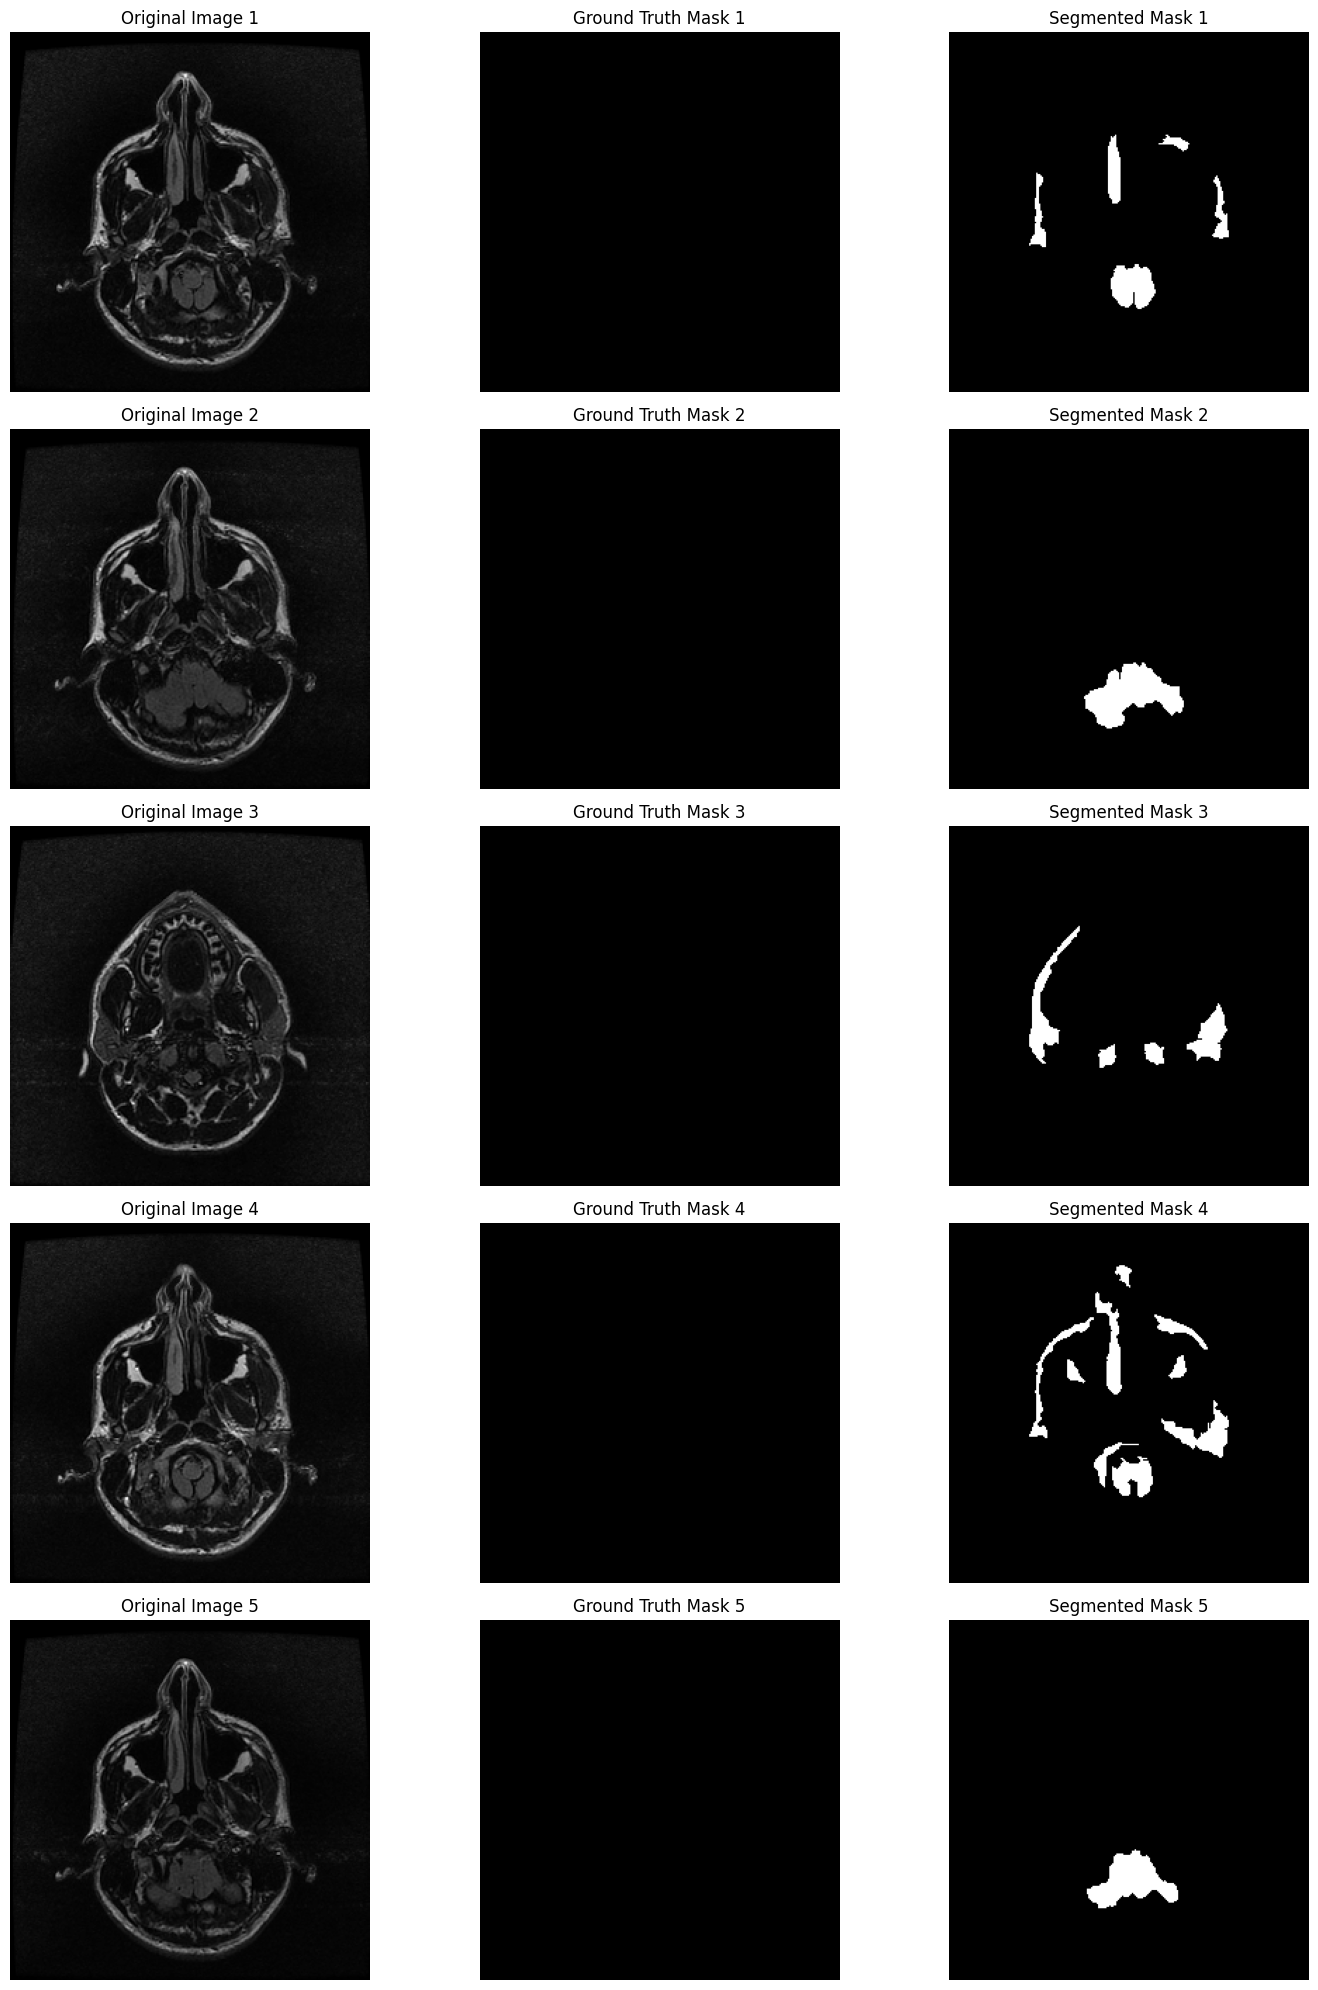

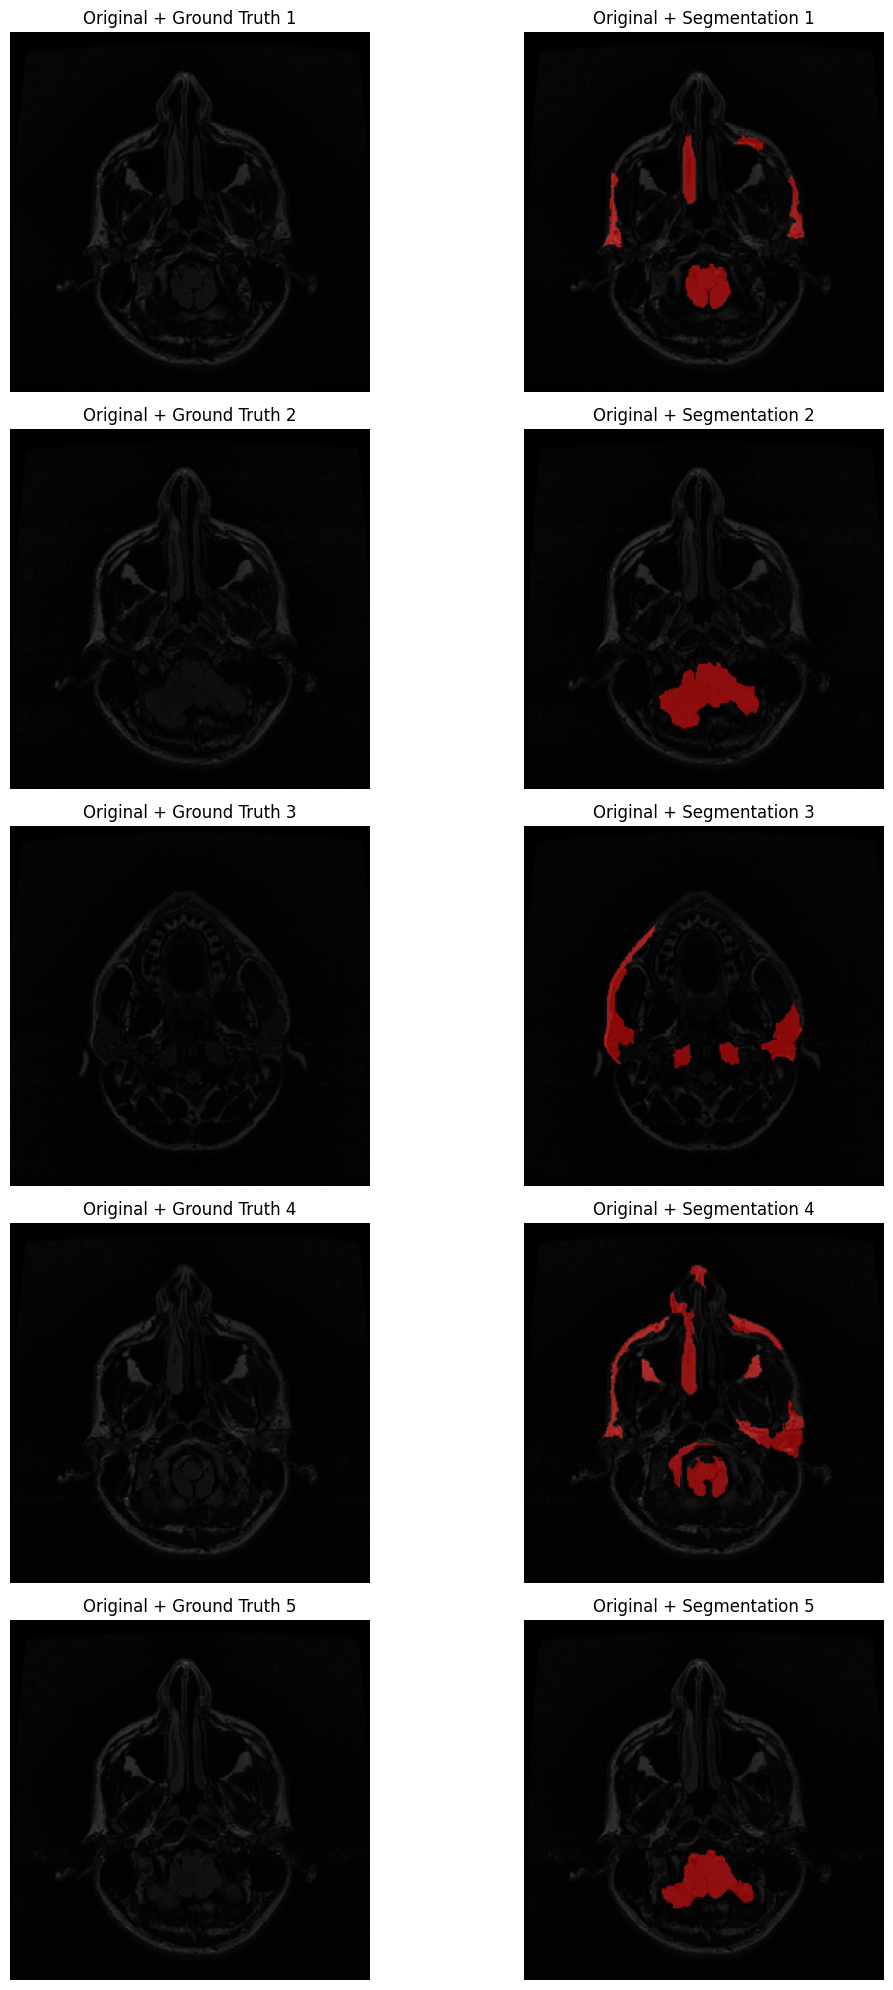


--------------------------------------------------
Running segmentation with KMEANS method
--------------------------------------------------
Loading dataset...
Loaded 30 images and 30 masks.
Preprocessing images...
Preprocessed 30 images.
Segmenting tumors using kmeans method...
Segmented 30 images.
Segmentation Evaluation Metrics:
  Dice Coefficient (F1-Score): 0.0000
  Jaccard Index (IoU): 0.0000
  Precision: 0.0000
  Recall: 1.0000


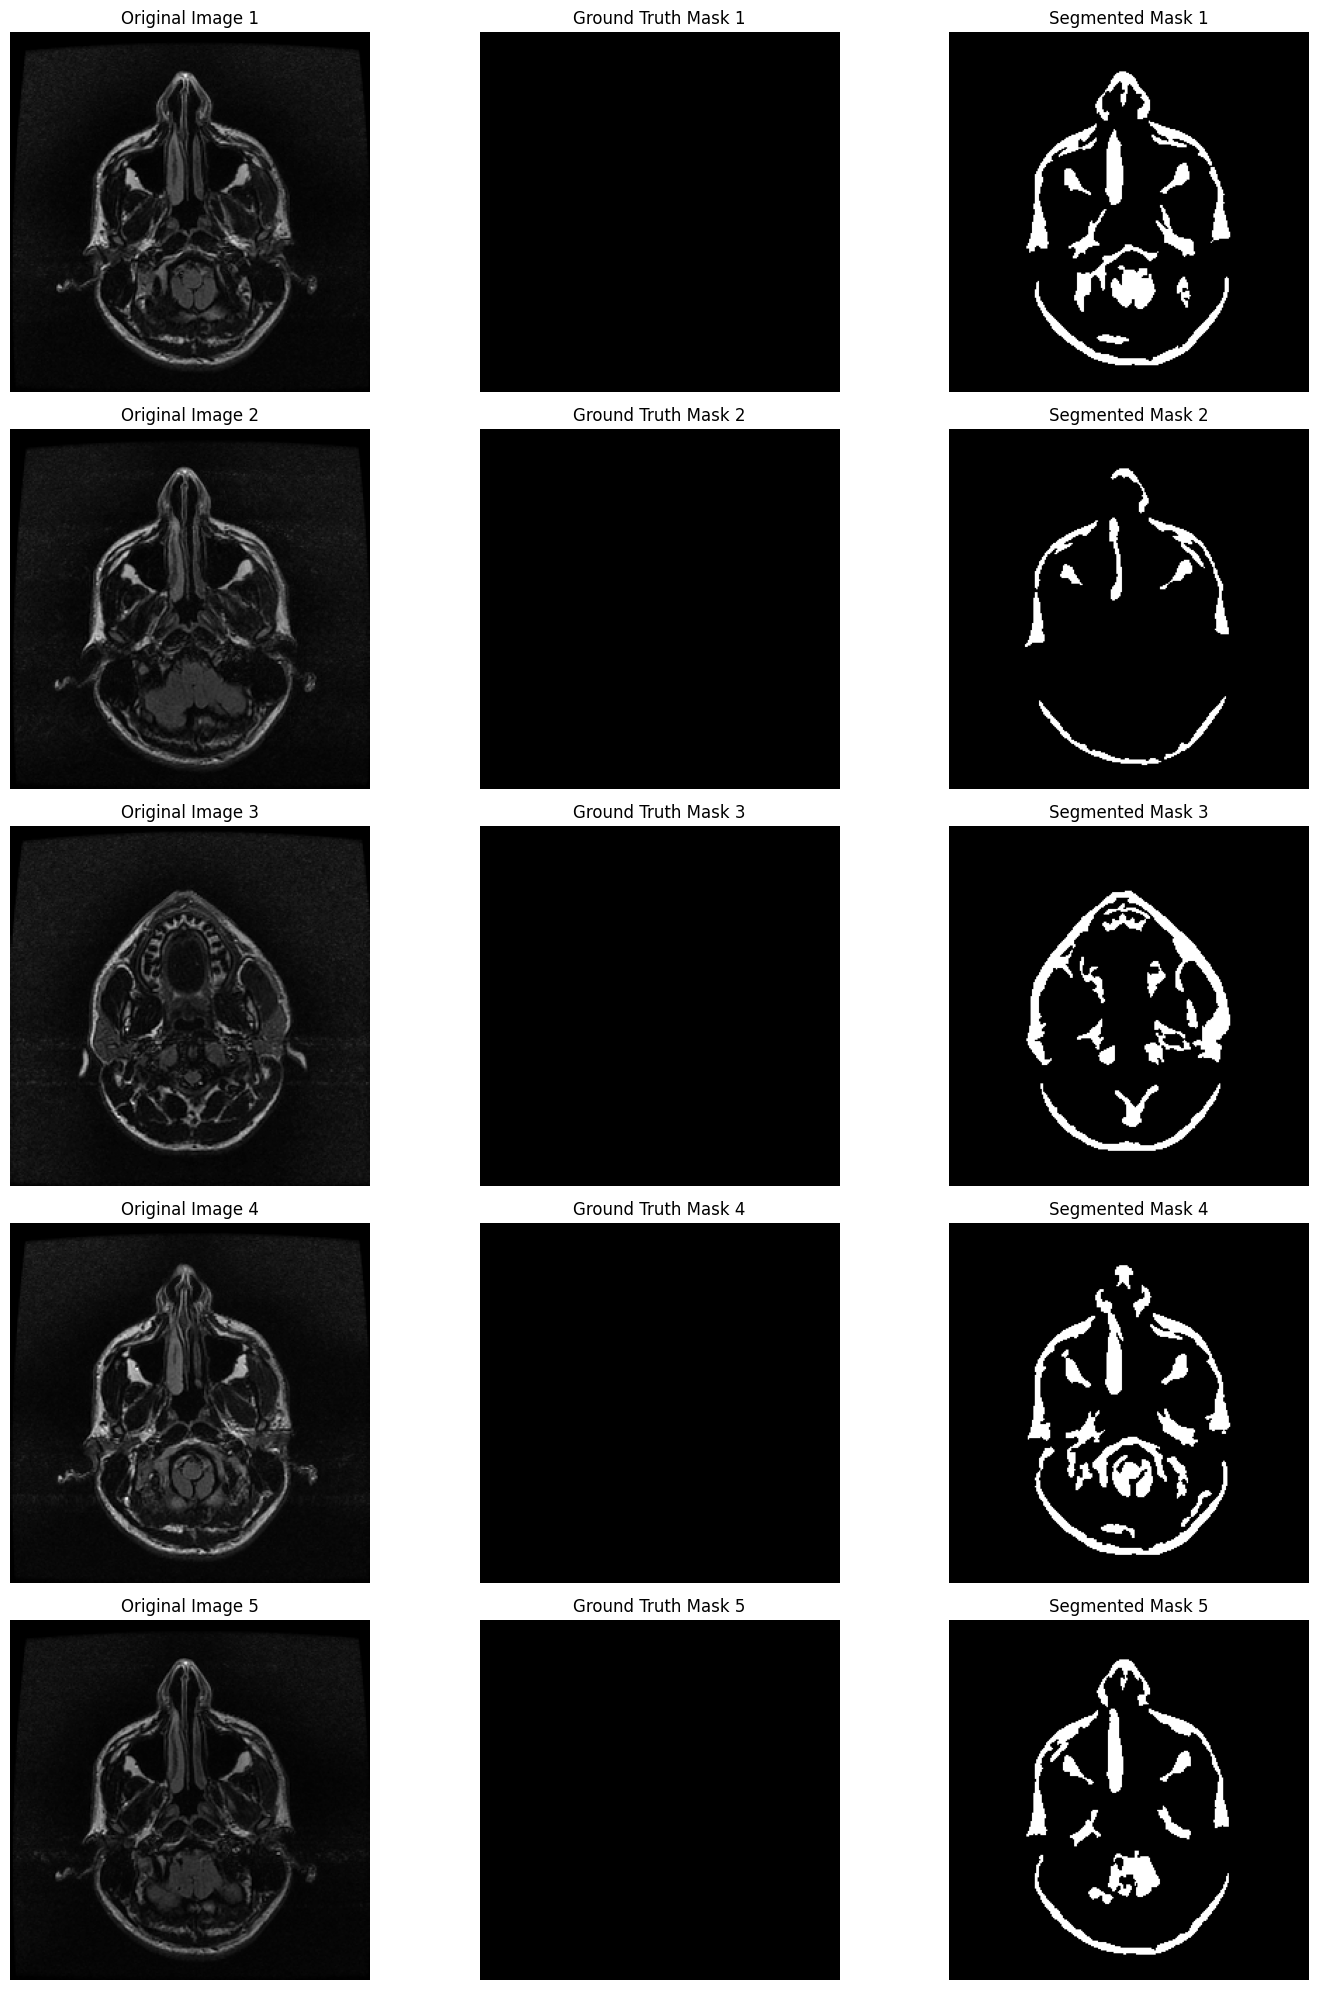

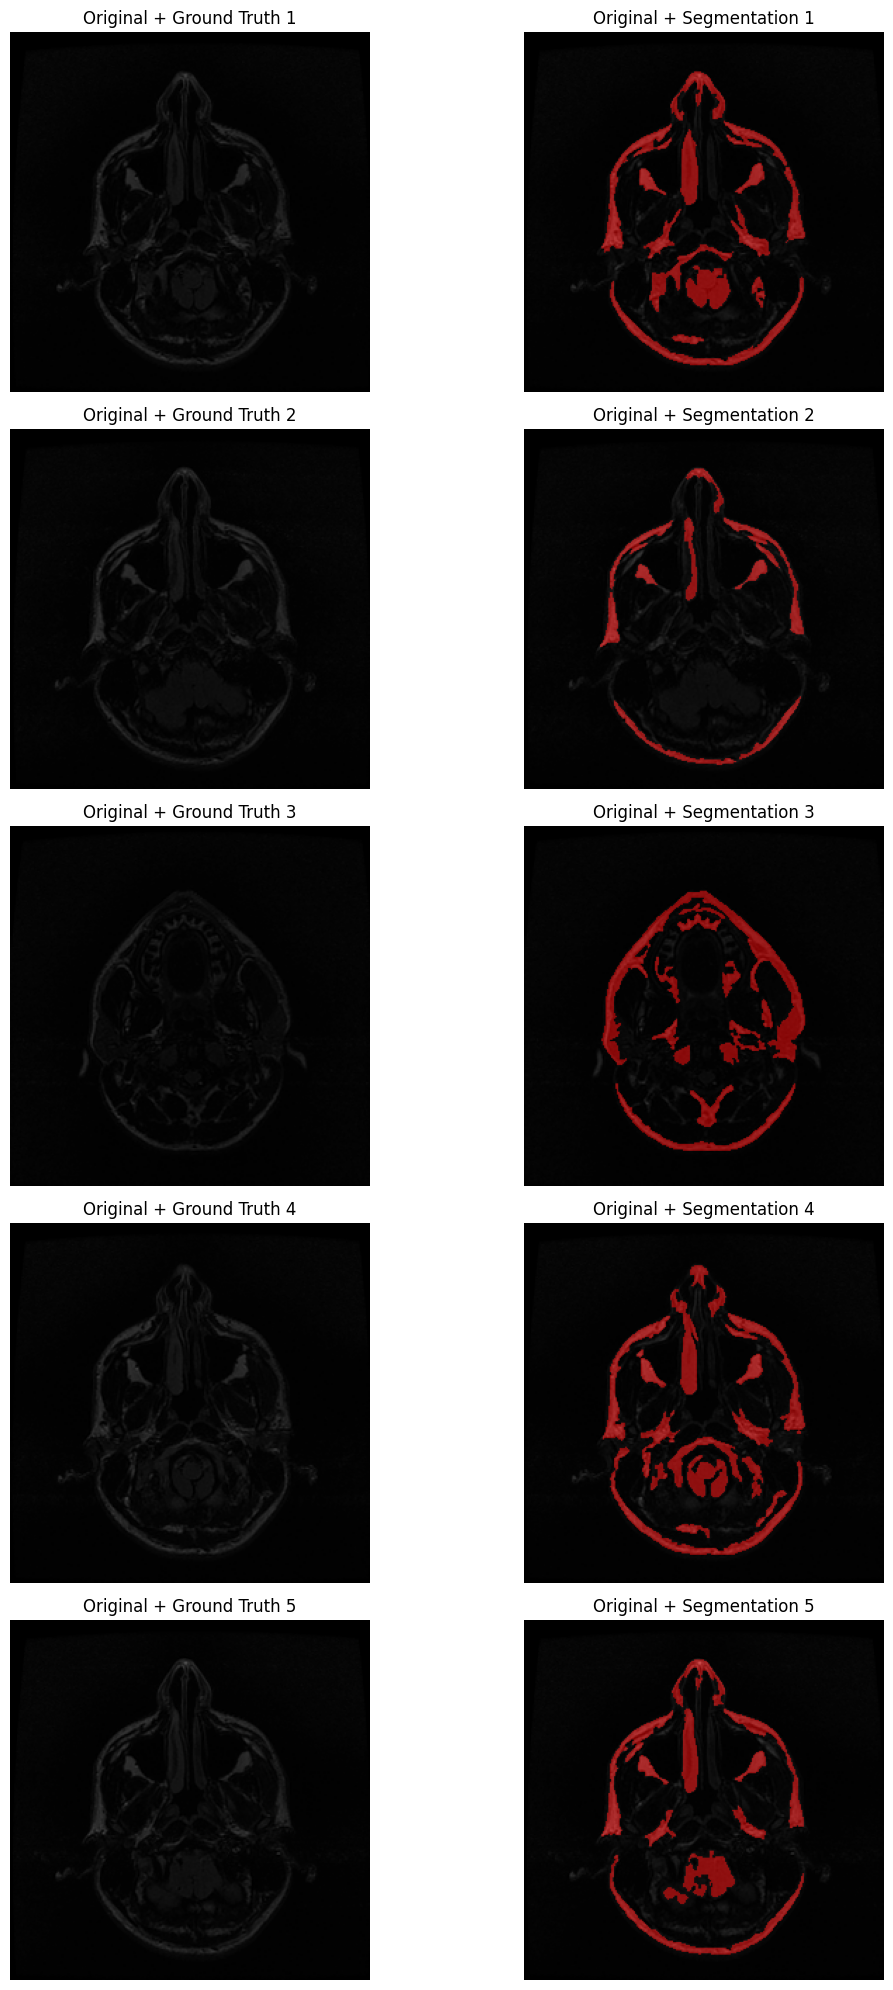


Comparison of Segmentation Methods:
Method       Dice     IoU      Precision  Recall  
--------------------------------------------------
threshold    0.0000  0.0000  0.0000    1.0000
watershed    0.0000  0.0000  0.0000    1.0000
kmeans       0.0000  0.0000  0.0000    1.0000


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, precision_score, recall_score

# Mount Google Drive (for Google Colab)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except:
    print("Running locally or Drive already mounted")

class BrainTumorSegmentation:
    def __init__(self, base_dir=None):
        """
        Initialize the Brain Tumor Segmentation class

        Parameters:
        -----------
        base_dir : str
            Base directory containing the dataset
        """
        self.base_dir = base_dir
        self.images = []
        self.masks = []
        self.processed_images = []
        self.segmented_masks = []
        self.metrics = {}

    def load_dataset(self, images_dir, masks_dir, max_samples=None):
        """
        Load dataset images and their corresponding masks

        Parameters:
        -----------
        images_dir : str
            Directory containing MRI scan images
        masks_dir : str
            Directory containing corresponding mask images
        max_samples : int, optional
            Maximum number of samples to load
        """
        print("Loading dataset...")

        # List all files in the directories
        image_files = sorted(os.listdir(images_dir))

        # For LGG dataset, find corresponding mask files
        loaded_count = 0

        for img_file in image_files:
            if not img_file.endswith(('.jpg', '.png', '.jpeg', '.tif')):
                continue

            # Construct mask filename based on LGG naming pattern
            if '_mask' not in img_file:
                mask_file = img_file.replace('.png', '_mask.png')
                mask_file = mask_file.replace('.tif', '_mask.tif')
                mask_file = mask_file.replace('.jpg', '_mask.jpg')

                image_path = os.path.join(images_dir, img_file)
                mask_path = os.path.join(masks_dir, mask_file)

                # Check if mask file exists
                if not os.path.exists(mask_path):
                    print(f"Warning: No mask found for {img_file}")
                    continue

                # Read image and mask
                image = cv2.imread(image_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                if image is not None and mask is not None:
                    # Handle grayscale vs color images
                    if len(image.shape) == 3 and image.shape[2] == 3:
                        # For LGG dataset: take FLAIR channel (usually the most informative)
                        # FLAIR is typically in the middle channel (index 1)
                        gray_image = image[:, :, 1]  # Extract FLAIR channel
                    else:
                        gray_image = image.copy()

                    # Convert to single channel and normalize
                    if len(gray_image.shape) == 3:
                        gray_image = cv2.cvtColor(gray_image, cv2.COLOR_BGR2GRAY)

                    # Normalize mask to binary (0 and 255)
                    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

                    # Add to the dataset
                    self.images.append(gray_image)
                    self.masks.append(binary_mask)

                    loaded_count += 1
                    if max_samples is not None and loaded_count >= max_samples:
                        break

        print(f"Loaded {len(self.images)} images and {len(self.masks)} masks.")

    def preprocess_images(self):
        """Preprocess the loaded MRI images"""
        print("Preprocessing images...")
        self.processed_images = []

        for image in self.images:
            # Ensure image is grayscale
            if len(image.shape) > 2:
                gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                gray_image = image.copy()

            # Normalize pixel values to range [0, 255]
            if gray_image.max() > 0:
                normalized = ((gray_image - gray_image.min()) /
                             (gray_image.max() - gray_image.min()) * 255).astype(np.uint8)
            else:
                normalized = gray_image

            # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced = clahe.apply(normalized)

            # Apply Gaussian blur to reduce noise
            blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

            # Store preprocessed image
            self.processed_images.append(blurred)

        print(f"Preprocessed {len(self.processed_images)} images.")

    def segment_tumors(self, method='watershed'):
        """
        Segment tumor regions from preprocessed images

        Parameters:
        -----------
        method : str
            Segmentation method to use ('threshold', 'watershed', 'kmeans')
        """
        print(f"Segmenting tumors using {method} method...")
        self.segmented_masks = []

        for image in self.processed_images:
            if method == 'threshold':
                # Apply Otsu's thresholding
                _, segmented = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            elif method == 'watershed':
                # Watershed algorithm
                # Find sure background
                _, thresholded = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

                # Noise removal with morphological operations
                kernel = np.ones((3, 3), np.uint8)
                opening = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=2)

                # Sure background area
                sure_bg = cv2.dilate(opening, kernel, iterations=3)

                # Finding sure foreground area
                dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
                _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

                # Finding unknown region
                sure_fg = np.uint8(sure_fg)
                unknown = cv2.subtract(sure_bg, sure_fg)

                # Marker labelling
                _, markers = cv2.connectedComponents(sure_fg)

                # Add one to all labels so that background is not 0, but 1
                markers = markers + 1

                # Mark the unknown region with 0
                markers[unknown == 255] = 0

                # Apply watershed
                markers = cv2.watershed(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), markers)
                segmented = np.zeros_like(image)
                segmented[markers > 1] = 255

            elif method == 'kmeans':
                # Apply K-means clustering
                image_data = image.reshape((-1, 1))
                image_data = np.float32(image_data)

                # Define criteria and apply kmeans
                criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
                k = 3  # Number of clusters
                _, labels, centers = cv2.kmeans(image_data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

                # Find the cluster that corresponds to the tumor (usually the brightest)
                centers = np.uint8(centers)
                brightest_cluster = np.argmax(centers)

                # Create mask based on the brightest cluster
                segmented = np.zeros_like(image)
                segmented[labels.reshape(image.shape) == brightest_cluster] = 255

            else:
                raise ValueError(f"Unknown segmentation method: {method}")

            # Post-processing: fill holes and remove small objects
            segmented = self.post_process_mask(segmented)
            self.segmented_masks.append(segmented)

        print(f"Segmented {len(self.segmented_masks)} images.")

    def post_process_mask(self, mask):
        """
        Apply post-processing to improve the segmentation mask

        Parameters:
        -----------
        mask : numpy.ndarray
            Binary segmentation mask

        Returns:
        --------
        numpy.ndarray
            Post-processed binary mask
        """
        # Convert to binary
        if mask.dtype != np.uint8:
            mask = mask.astype(np.uint8)

        # Fill holes
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filled_mask = np.zeros_like(mask)
        cv2.drawContours(filled_mask, contours, -1, 255, -1)

        # Remove small objects (noise)
        nb_components, output, stats, _ = cv2.connectedComponentsWithStats(filled_mask, connectivity=8)
        sizes = stats[1:, -1]
        min_size = 100  # Minimum size of objects to keep

        # Keep only components with size greater than min_size
        processed_mask = np.zeros_like(filled_mask)
        for i in range(1, nb_components):
            if sizes[i - 1] >= min_size:
                processed_mask[output == i] = 255

        return processed_mask

    def evaluate_segmentation(self, ground_truth_masks=None):
        """
        Evaluate segmentation performance against ground truth masks

        Parameters:
        -----------
        ground_truth_masks : list
            List of ground truth mask images

        Returns:
        --------
        dict
            Dictionary containing evaluation metrics
        """
        if ground_truth_masks is None:
            ground_truth_masks = self.masks

        if len(ground_truth_masks) != len(self.segmented_masks):
            raise ValueError("Mismatch between number of ground truth masks and segmented masks")

        # Initialize metrics
        dice_scores = []
        jaccard_scores = []
        precision_scores = []
        recall_scores = []

        for gt_mask, pred_mask in zip(ground_truth_masks, self.segmented_masks):
            # Binarize masks
            gt_binary = np.where(gt_mask > 0, 1, 0).flatten()
            pred_binary = np.where(pred_mask > 0, 1, 0).flatten()

            # Calculate Dice coefficient (F1 score)
            dice = f1_score(gt_binary, pred_binary, zero_division=1)
            dice_scores.append(dice)

            # Calculate Jaccard index (IoU)
            iou = jaccard_score(gt_binary, pred_binary, zero_division=1)
            jaccard_scores.append(iou)

            # Calculate precision and recall
            precision = precision_score(gt_binary, pred_binary, zero_division=1)
            recall = recall_score(gt_binary, pred_binary, zero_division=1)

            precision_scores.append(precision)
            recall_scores.append(recall)

        # Calculate average metrics
        self.metrics = {
            'dice_coefficient': np.mean(dice_scores),
            'jaccard_index': np.mean(jaccard_scores),
            'precision': np.mean(precision_scores),
            'recall': np.mean(recall_scores)
        }

        print("Segmentation Evaluation Metrics:")
        print(f"  Dice Coefficient (F1-Score): {self.metrics['dice_coefficient']:.4f}")
        print(f"  Jaccard Index (IoU): {self.metrics['jaccard_index']:.4f}")
        print(f"  Precision: {self.metrics['precision']:.4f}")
        print(f"  Recall: {self.metrics['recall']:.4f}")

        return self.metrics

    def visualize_results(self, num_samples=5):
        """
        Visualize original images, ground truth masks, and segmented masks

        Parameters:
        -----------
        num_samples : int
            Number of samples to visualize
        """
        num_samples = min(num_samples, len(self.images))

        plt.figure(figsize=(15, 4 * num_samples))

        for i in range(num_samples):
            # Original image
            plt.subplot(num_samples, 3, i * 3 + 1)
            plt.imshow(self.images[i], cmap='gray')
            plt.title(f"Original Image {i+1}")
            plt.axis('off')

            # Ground truth mask
            plt.subplot(num_samples, 3, i * 3 + 2)
            plt.imshow(self.masks[i], cmap='gray')
            plt.title(f"Ground Truth Mask {i+1}")
            plt.axis('off')

            # Segmented mask
            plt.subplot(num_samples, 3, i * 3 + 3)
            plt.imshow(self.segmented_masks[i], cmap='gray')
            plt.title(f"Segmented Mask {i+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    def overlay_results(self, num_samples=5):
        """
        Overlay segmentation results on original images for visualization

        Parameters:
        -----------
        num_samples : int
            Number of samples to visualize
        """
        num_samples = min(num_samples, len(self.images))

        plt.figure(figsize=(12, 4 * num_samples))

        for i in range(num_samples):
            # Convert image to RGB for overlay
            display_img = cv2.cvtColor(self.images[i], cv2.COLOR_GRAY2RGB)

            # Original image with ground truth overlay
            plt.subplot(num_samples, 2, i * 2 + 1)

            # Create overlay with ground truth mask (green)
            overlay = display_img.copy()

            # Create green mask
            green_mask = np.zeros_like(overlay)
            green_mask[:, :, 1] = self.masks[i]  # Green channel

            # Apply mask
            alpha = 0.5
            cv2.addWeighted(green_mask, alpha, overlay, 1 - alpha, 0, overlay)

            plt.imshow(overlay)
            plt.title(f"Original + Ground Truth {i+1}")
            plt.axis('off')

            # Original image with segmentation overlay
            plt.subplot(num_samples, 2, i * 2 + 2)

            # Create overlay with segmented mask (red)
            overlay = display_img.copy()

            # Create red mask
            red_mask = np.zeros_like(overlay)
            red_mask[:, :, 0] = self.segmented_masks[i]  # Red channel

            # Apply mask
            cv2.addWeighted(red_mask, alpha, overlay, 1 - alpha, 0, overlay)

            plt.imshow(overlay)
            plt.title(f"Original + Segmentation {i+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    def run_full_pipeline(self, images_dir, masks_dir, max_samples=None, segmentation_method='watershed'):
        """
        Run the full segmentation pipeline

        Parameters:
        -----------
        images_dir : str
            Directory containing MRI scan images
        masks_dir : str
            Directory containing corresponding mask images
        max_samples : int, optional
            Maximum number of samples to load
        segmentation_method : str
            Method to use for segmentation ('threshold', 'watershed', 'kmeans')
        """
        # Load dataset
        self.load_dataset(images_dir, masks_dir, max_samples)

        # Preprocess images
        self.preprocess_images()

        # Segment tumors
        self.segment_tumors(method=segmentation_method)

        # Evaluate segmentation
        self.evaluate_segmentation()

        # Visualize results
        self.visualize_results()
        self.overlay_results()

        return self.metrics

# Execute the segmentation pipeline
if __name__ == "__main__":
    # Update these paths to your LGG dataset location
    base_dir = '/content/drive/MyDrive/brain_tumor_dataset'
    images_dir = os.path.join(base_dir, 'images')
    masks_dir = os.path.join(base_dir, 'masks')

    # Create segmentation object
    tumor_segmentation = BrainTumorSegmentation(base_dir)

    # Run full pipeline with all available segmentation methods
    methods = ['threshold', 'watershed', 'kmeans']
    results = {}

    for method in methods:
        print(f"\n{'-'*50}")
        print(f"Running segmentation with {method.upper()} method")
        print(f"{'-'*50}")

        metrics = tumor_segmentation.run_full_pipeline(
            images_dir=images_dir,
            masks_dir=masks_dir,
            max_samples=10,  # Use 10 images as requested
            segmentation_method=method
        )

        results[method] = metrics

    # Compare results
    print("\nComparison of Segmentation Methods:")
    print(f"{'Method':<12} {'Dice':<8} {'IoU':<8} {'Precision':<10} {'Recall':<8}")
    print("-" * 50)

    for method, metrics in results.items():
        print(f"{method:<12} {metrics['dice_coefficient']:.4f}  {metrics['jaccard_index']:.4f}  "
              f"{metrics['precision']:.4f}    {metrics['recall']:.4f}")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
